In [ ]:
%load_ext autoreload
%autoreload 2

In [ ]:
import pandas as pd
import numpy as np

import plotly.graph_objects as go
from plotly.subplots import make_subplots

from helper import groupby_consecutive

import sys

sys.path.append("..")
from plotly_resampler import FigureResampler, FigureWidgetResampler, EveryNthPoint


USE_PNG = True  # Set to false to use dynamic plots


# Adding dynamic aggregation to your plotly Figure

In [ ]:
# Some dummy data that will be used throughout the examples
n = 2_000_000
x = np.arange(n)
noisy_sine = (3 + np.sin(x / 2000) + np.random.randn(n) / 10) * x / (n / 4)


## **auto mode**: `register_plotly_resampler`

Once `register_plotly_resampler` method is called, it will automatically convert all new defined plotly graph objects into a `FigureResampler` or `FigureWidgetResampler` object. The `mode` parameter of this method allows to define which type of the aforementioned resampling objects is used.

✅ **advantages**:
* This is the most convenient way to make your existing codebase more scalable
* You can keep on using your regular graph construction code

❌ **disadvantages**:
* all figures will be wrapped with plotly-resampler behavior (less control)
* if you want to go the extra mile regarding graph construction performance, it is better to use the `FigureResampler` or `FigureWidgetResampler` components individually.

In [ ]:
from plotly_resampler import register_plotly_resampler, unregister_plotly_resampler


In [ ]:
# by default, 1,000 samples per trace are shown
register_plotly_resampler(mode="auto", default_n_shown_samples=4500)


In [8]:
# auto mode: when working in an IPython environment, this will automatically be a
# FigureWidgetResampler else, this will be an FigureResampler
fig = go.Figure()
fig.add_traces(
    [
        {"y": noisy_sine + 2, "name": "yp2", "type": "scattergl"},
        {'y': noisy_sine - 3, 'name': 'ym1', "type": "scatter"},
    ]
)
print(type(fig))
display(fig)


<class 'plotly_resampler.figure_resampler.figure_resampler.FigureResampler'>


❗ `.show()` always returns a static html view

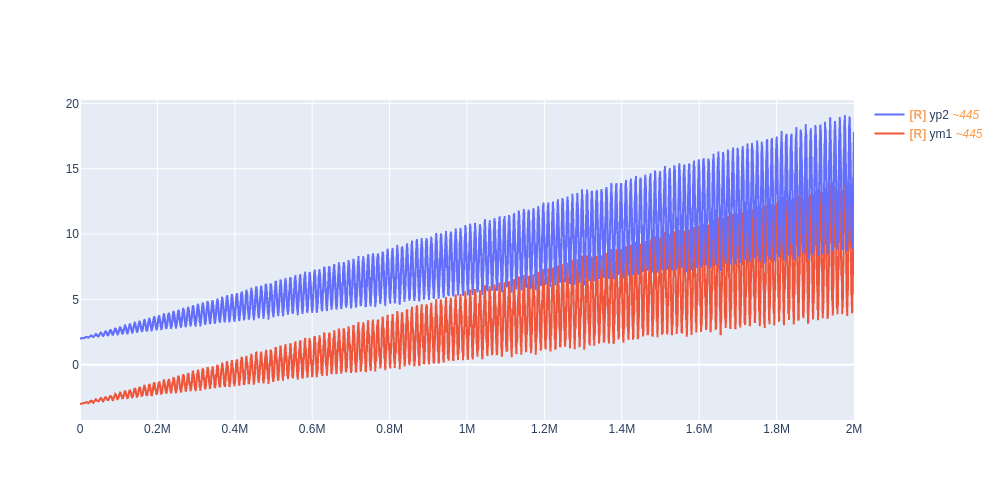

In [12]:
# this outputs a static html view of the figure, which can be serialized within notebooks
if USE_PNG:
    unregister_plotly_resampler()
    go.Figure(fig).show(renderer="png", width=1000, height=500)
else:
    fig.show()

### pro tip: `register_plotly_resampler` + pandas plotting backend = 🔥

The combo below allows to conveniently visualize large time_series data

In [13]:
register_plotly_resampler(mode="auto", default_n_shown_samples=1500)
# pd.options.plotting.backend = 'plotly'


In [14]:
df = pd.DataFrame(data={"sine": noisy_sine, "neg-sine": -noisy_sine}, copy=False)
df


,sine,neg-sine
0,0.000000,-0.000000
1,0.000006,-0.000006
2,0.000012,-0.000012
3,0.000018,-0.000018
4,0.000024,-0.000024
...,...,...
1999995,15.505089,-15.505089
1999996,14.208833,-14.208833
1999997,15.817249,-15.817249
1999998,15.721537,-15.721537


In [15]:
# TODO: for some reason pandas plotting backend + datetime index work really slow
# df.index = pd.date_range(start="2020-01-01", periods=len(df), freq="1s")

In [16]:
df.plot(backend="plotly")


FigureWidgetResampler({
    'data': [{'hovertemplate': 'variable=sine<br>index=%{x}<br>value=%{y}<extra></extr…

In [17]:
unregister_plotly_resampler()

## **manual mode**: Basic sine example



✅ **advantages**:
* Highly configurable (e.g., downsampler per trace, number of shown sample per trace)
* Most optimizable (by leveraging the `hf_` arguments)

❌ **disadvantages**:
* more tedious (more code needs to be written)

This example shows how the `FigureResampler` can be used to efficiently construct a graph

In [18]:
# 1. Wrap the figure with the FigureResampler class
fig = FigureResampler(go.Figure())

# Add the trace using the `hf_x` & `hf_y` for faster rendering
# (this does not impact the resampling speed once rendered)
fig.add_trace(go.Scattergl(showlegend=True), hf_x=x, hf_y=noisy_sine, max_n_samples=300)
# Note how a dict input is also valid and how different # of samples per trace are used
fig.add_trace(dict(x=x, y=noisy_sine + 1, name='sp1'), max_n_samples=2000)

# Optional: update the layout
fig.update_layout(height=400, template="plotly_dark")

# 2. Call show_dash
fig.show_dash(mode="inline")


For the `FigureWidgetResampler` use case, you only need to chance way of displaying the figure

In [19]:
# Same content as above, but using the FigureWidgetResampler class
fig = FigureWidgetResampler(go.Figure())
fig.add_trace(go.Scattergl(showlegend=True), hf_x=x, hf_y=noisy_sine, max_n_samples=200)
fig.add_trace(dict(x=x, y=noisy_sine + 1, name='sp1'), max_n_samples=2000)
fig.update_layout(height=400, template="plotly_dark")

# Displaying the figure -> instead of `show_dash`, use IPython's `display`
display(fig)


FigureWidgetResampler({
    'data': [{'name': '<b style="color:sandybrown">[R]</b> trace 0 <i style="color:#fc…

In [20]:
# Same content as above, but using the FigureWidgetResampler class
fig = FigureWidgetResampler(go.Figure())
fig.add_trace(go.Scattergl(showlegend=True), hf_x=x, hf_y=noisy_sine, max_n_samples=900)
fig.update_layout(height=400, template="plotly_dark")

# Displaying the figure -> instead of `show_dash`, use IPython's `display`
display(fig)


FigureWidgetResampler({
    'data': [{'name': '<b style="color:sandybrown">[R]</b> trace 0 <i style="color:#fc…

# Advanced stuff

## `plotly-resampler` notebook figure retention|serialization

It is often useful to still retain a figure after your notebook is disconnected from your python kernel, e.g., when exported to html.

To this end, the `"inline_persistent"` argument was added to the `FigureResampler.show_dash` which outputs a static image (of the global aggregated view) when the kernel is disconnected.<br>
The example below illustrates this behavior

> **Note**: 
> * you must have `kaleido` installed for this to work.
> * The static output figure will only be shown in environments where javascript code is allowed to execute.

<details> <summary><b>How is this implemented?</b></summary>
We create a JupyterDash subclass which extends the "inline" visualization capabilities with the functionality described above.<br>
This extension is triggered when <i>"inline_persistent"</i> is used in the <code>FigureResampler.show_dash</code> method.<br>

<ul>
    <li>we add a unique _uid to each object</li>
    <li>we add a new endpoint to the underlying flask app that</li><ul>
        <li>is only accessible via the corresponding app its _uid</li>
        <li>has CORS rights for any origin and 'Content-Type' headers</li>
        </ul>
        <li>Note that this is the only CORS endpoint of the JupyterDash app & is only preset when "inline_persistent" is used!</li>
    <li>we check in the JavaScript output of the notebook cell whether that endpoint is reachable and emits the expected message (i.e., "Alive")</li><ul>
        <li>if check is successful => display an iframe of the running Jupyter dash app</li>
        <li>if check is not successful => display a static image</li>
    </ul>
</ul>
</details>
<details> <summary><b>How does this work?</b></summary>
    Some additional JavaScript code is added to the <code>IPython.display.display</code> method, which contains a <i>base64</i> bytarray image of the shown figure.<br>
    When the dash app is not reachable, the image is shown instead of the iframe (which embedded the connected dash app).<br>
    This works because the JavaScript in the notebook output cells gets executed each time a notebook is loaded (❗the kernel should not be running for this to happen).
</details>

In [21]:
fig = FigureResampler(go.Figure())
fig.add_trace(go.Scattergl(showlegend=True), hf_x=x, hf_y=noisy_sine, max_n_samples=900)
fig.update_layout(height=400, template="plotly_white")

# Displaying the figure -> instead of `show_dash`, use IPython's `display`
fig.show_dash(mode="inline_persistent")

When you:
* restart the kernel; and reopen this notebook
* export this notebook to html

you should see a static (aggregated) image of the above figure

## Adjusting the data of your plotly-resampler figure at runtime

The `hf_data` property of the `FigureResampler` / `FigureWidgetResampler` can be used to change figure data at runtime

### `FigureResampler`

In [22]:
fig = FigureResampler(go.Figure())
fig.add_trace(go.Scattergl(showlegend=True, name="noisy_sine"), hf_y=noisy_sine)
display(fig.hf_data)
fig.show_dash(mode="inline")


[{'max_n_samples': 1000,
  'default_n_samples': True,
  'x': RangeIndex(start=0, stop=2000000, step=1),
  'y': array([0.00000000e+00, 5.91612858e-06, 1.20245247e-05, ...,
         1.58172489e+01, 1.57215371e+01, 1.52863114e+01]),
  'axis_type': 'linear',
  'downsampler': <plotly_resampler.aggregation.aggregators.EfficientLTTB at 0x7fe93c3ab940>,
  'default_downsampler': True,
  'text': None,
  'hovertext': None}]

Now we adjust the figure data  
**Note**: after running the cell below, we need to manually trigger a graph update (by for example zooming / resetting the axes) to ensure that the new data is shown.

In [23]:
fig.hf_data[0]["y"] = -10 * noisy_sine
# make sure to interact win the figure to see the change


### `FigureWidgetResampler`

In [24]:
fig = FigureWidgetResampler(go.Figure())
fig.add_trace(go.Scattergl(showlegend=True, name="noisy_sine"), hf_y=noisy_sine)
display(fig.hf_data)
display(fig)


[{'max_n_samples': 1000,
  'default_n_samples': True,
  'x': RangeIndex(start=0, stop=2000000, step=1),
  'y': array([0.00000000e+00, 5.91612858e-06, 1.20245247e-05, ...,
         1.58172489e+01, 1.57215371e+01, 1.52863114e+01]),
  'axis_type': 'linear',
  'downsampler': <plotly_resampler.aggregation.aggregators.EfficientLTTB at 0x7fe9377e4ca0>,
  'default_downsampler': True,
  'text': None,
  'hovertext': None}]

FigureWidgetResampler({
    'data': [{'name': '<b style="color:sandybrown">[R]</b> noisy_sine <i style="color:…

Now we adjust the figure data  
**Note**: after running the cell below, we need to manually trigger a graph update (by for example zooming / resetting the axes) to ensure that the new data is shown.

In [25]:
fig.hf_data[0]["y"] = 10 * noisy_sine**2


**Pro tip**: `FigureWidgetResampler` has the `reload_data` and `reset_axes` methods to do this automatically

In [26]:
fig.hf_data[0]["y"] = -10 * noisy_sine**2
# the reload data function keeps the current zoom level
fig.reload_data()


In [27]:
fig.hf_data[0]["y"] = 10 * noisy_sine**.1
# the reset axes
fig.reset_axes()


## Adding confidence/error bounds to your time series data

To achieve this one needs to do the following:

use the `add_trace` method *in this order* to:
1. Add your high-frequency trace
2. Add the upper and lower bounds invididually; use no concatenate tricks and fill toself

> **Note**: We add the confidence bound traces seperately, which allows us:
> * to create monotonically increasing time-series
> * to use the `fill="tonexty"` argument when adding the 2nd bound trace.

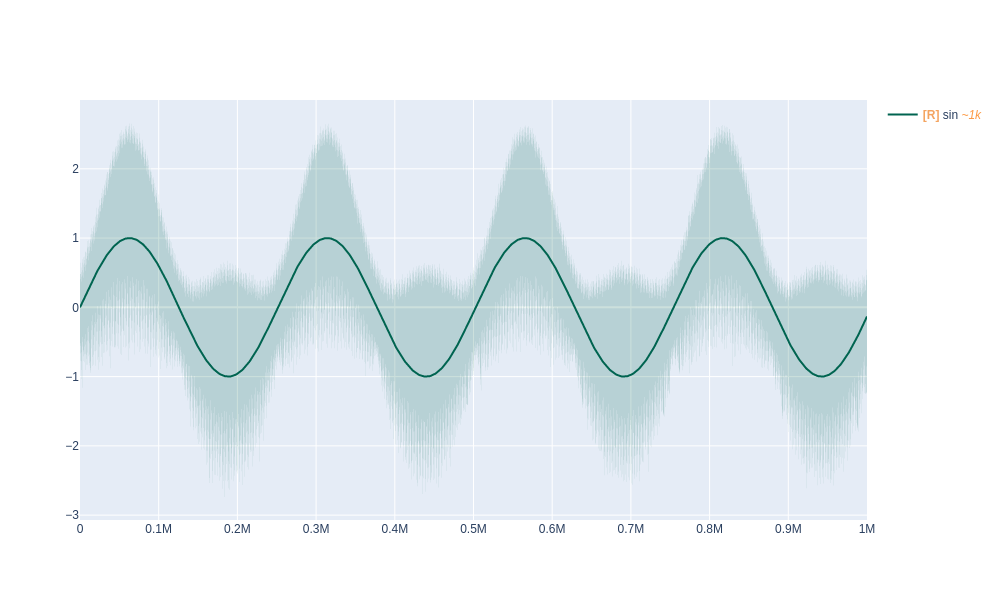

Dash app running on http://127.0.0.1:9012/


In [46]:
# Construct the data
n_vis = 1_000_000
x_vis = np.arange(n_vis) + 1
y_vis = np.sin(x_vis / (n_vis / 25))

# Construct the upper and lower bounds
upper = y_vis + 0.5 + (y_vis) ** 2 + np.random.randn(n_vis) * 0.05
lower = np.min(
    [y_vis - 0.5, y_vis - (abs(y_vis) ** 0.5 + np.random.randn(n_vis) * 0.2)], axis=0
)

# 0. Create the figure
fig = FigureResampler(go.Figure())

# 1.  add the traae
fig.add_trace(go.Scatter(x=x_vis, y=y_vis, line_color="rgb(0,100,80)", name="sin"))

# 2. add the bounds
# NOTE: we use two monotonic increasing traces to fill the area
fig.add_trace(go.Scatter(x=x_vis, y=upper, line_width=0, showlegend=False))
fig.add_trace(
    go.Scatter(
        x=x_vis,
        y=lower,
        line_width=0,
        fill="tonexty",  # fill to the previous trace
        fillcolor="rgba(0,100,80,0.2)",
        showlegend=False,
    )
)

# 3. show the figure
fig.show(renderer="png", width=1000, height=600)
fig.show_dash(mode="external", port=9012)

del x_vis, y_vis, n_vis


## Different downsampler & number of shown samples per trace

To achieve this, you only need to adjust the `max_n_samples` per trace; see the example below

In [30]:
fig = FigureResampler(go.Figure())

fig.add_trace(go.Scattergl(showlegend=True), hf_x=x, hf_y=noisy_sine, max_n_samples=100)
fig.add_trace(dict(x=x, y=noisy_sine + 1, name="sp1"), max_n_samples=2000)
fig.add_trace(
    dict(x=x, y=noisy_sine + 5, name="sp5"),
    max_n_samples=300,
    downsampler=EveryNthPoint(),
)


# Optional: update the layout
fig.update_layout(height=400, template="plotly_dark")

# 2. Call show_dash
fig.show_dash(mode="inline_persistent")


---

# Various other examples

The visualizations below shows how you plotly-resampler is used for various visualization configurations.

## The example `.gif` from the docs/README

Note how:
* The example figure withholds both time-indexed data and numeric-indexed data
* The power-consumption data uses `2,000` samples per trace (`max_n_samples`), whilst the other signals use the default of `1,000` samples per trace.
* The swimming pool trace uses another downsampling method (`EveryNthPoint`)
* The swimming pool trace uses `hf_hovertext` which shows the mean # of pool visitors of the last hour. 


In [31]:
# ------------ loading the data -----------
df_gusb = pd.read_parquet("data/df_gusb.parquet")
df_data_pc = pd.read_parquet("data/df_pc_test.parquet")

# Create a noisy sine
n = 110_000_00  # 0
x = np.arange(n)
noisy_sine = (3 + np.sin(x / 200_000) + np.random.randn(n) / 10) * x / 100_000


In [33]:
fig = FigureResampler(
    make_subplots(
        rows=2,
        cols=2,
        specs=[[{}, {}], [{"colspan": 2}, None]],
        subplot_titles=("GUSB swimming pool", "Generated sine", "Power consumption"),
        vertical_spacing=0.12,
    ),
    default_n_shown_samples=1000,
    verbose=False,
)


# ------------ swimming pool data -----------
df_gusb_pool = df_gusb["zwembad"].last("4D").dropna()
fig.add_trace(
    go.Scattergl(
        x=df_gusb_pool.index,
        y=df_gusb_pool.astype("uint16"),
        mode="markers",
        marker_size=5,
        name="occupancy",
        # showlegend=False,
    ),
    hf_hovertext="mean last hour: "
    + df_gusb_pool.rolling("1h").mean().astype(int).astype(str),
    downsampler=EveryNthPoint(interleave_gaps=False),
    row=1,
    col=1,
)
fig.update_yaxes(title_text="Occupancy", row=1, col=1)


# ----------------- generated sine -----------
fig.add_trace(
    dict(name="sin", line_color="#26b2e0"),
    hf_x=x,
    hf_y=noisy_sine,
    row=1,
    col=2,
)

# ------------- Power consumption data -------------
df_data_pc = df_data_pc.last("190D")
for i, c in enumerate(df_data_pc.columns):
    fig.add_trace(
        go.Scattergl(name=f"R-{i+1}", line_width=1),
        hf_x=df_data_pc.index,
        hf_y=df_data_pc[c],
        max_n_samples=2_000,  # The power consumption data uses 2,000 samples per trace
        row=2,
        col=1,
    )

fig.update_layout(height=650)
fig.update_yaxes(title_text="Watt/hour", row=2, col=1)
fig.update_layout(
    title="<b>Plotly-Resampler demo</b>",
    title_x=0.5,
    legend_traceorder="normal",
    legend=dict(orientation="h", y=1.11, xanchor="left", x=0),
)

fig.show_dash(mode="inline_persistent", debug=True, port=9029)


## Converting a `go.Figure`, with its traces, into a `FigureResampler`

This example first creates the `.gif` figure (with less data, otherwise the graph construction time would be too long) and then uses the  `convert_existing_traces` argument of the FigureResampler constructor to convert this into a FigureResampler figure.

In [34]:
from plotly_resampler import unregister_plotly_resampler
unregister_plotly_resampler()

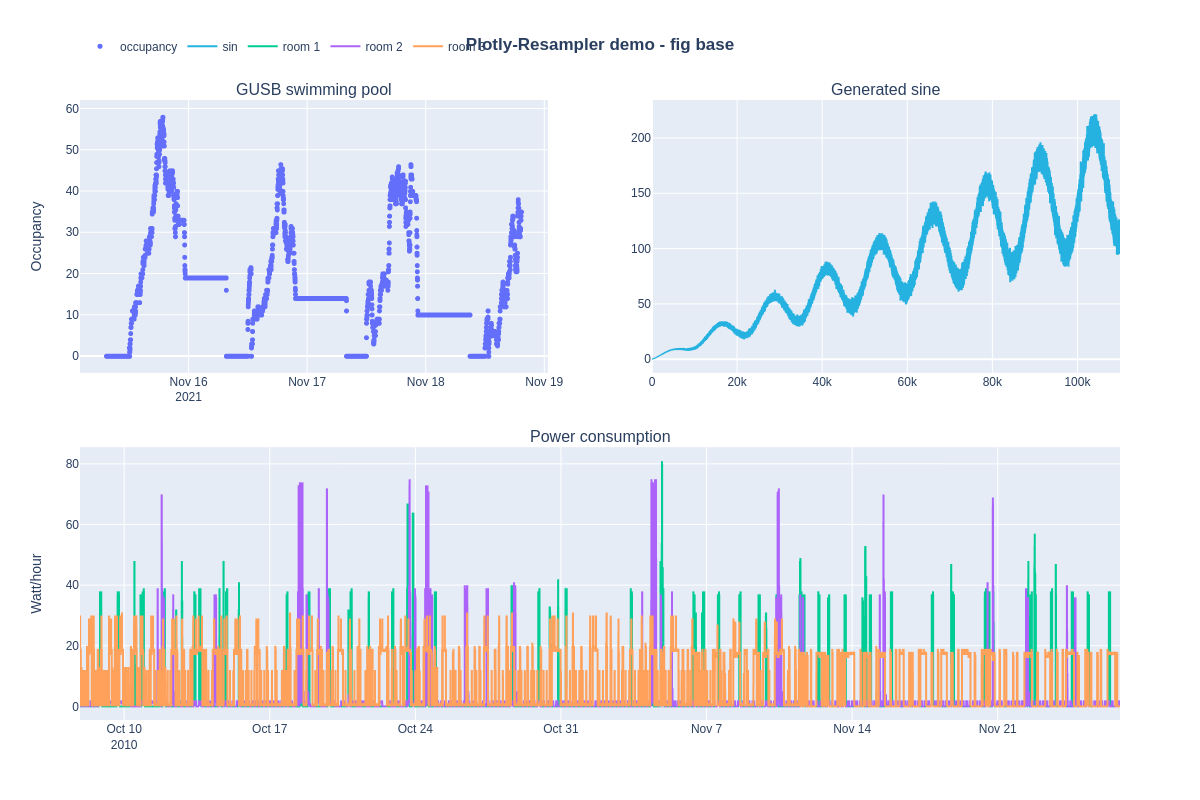

In [36]:
df_gusb = pd.read_parquet(f"data/df_gusb.parquet")
df_data_pc = pd.read_parquet(f"data/df_pc_test.parquet")

n = 110_000
x = np.arange(n)
noisy_sine = (3 + np.sin(x / 2_000) + np.random.randn(n) / 10) * x / 2_000

# construct a normal figure object instead of a figureResample object
fig = make_subplots(
    rows=2,
    cols=2,
    specs=[[{}, {}], [{"colspan": 2}, None]],
    subplot_titles=("GUSB swimming pool", "Generated sine", "Power consumption"),
    vertical_spacing=0.12,
)


# ------------ swimming pool data -----------
df_gusb_pool = df_gusb["zwembad"].last("4D").dropna()
fig.add_trace(
    go.Scattergl(
        x=df_gusb_pool.index,
        y=df_gusb_pool,  # .astype("uint16"),
        mode="markers",
        marker_size=5,
        name="occupancy",
        showlegend=True,
        hovertext="mean last hour: "
        + df_gusb_pool.rolling("1h").mean().astype(int).astype(str),
    ),
    # downsampler=EveryNthPoint(interleave_gaps=False),
    row=1,
    col=1,
)
fig.update_yaxes(title_text="Occupancy", row=1, col=1)


# ----------------- generated sine -----------
fig.add_trace(
    go.Scattergl(name="sin", line_color="#26b2e0", x=x, y=noisy_sine),
    row=1,
    col=2,
)

# ------------- Power consumption data -------------
df_data_pc = df_data_pc.last("50D")
for i, c in enumerate(df_data_pc.columns):
    fig.add_trace(
        go.Scattergl(
            name=f"room {i+1}",
            x=df_data_pc.index,
            y=df_data_pc[c],
        ),
        row=2,
        col=1,
    )

fig.update_layout(height=600)
fig.update_yaxes(title_text="Watt/hour", row=2, col=1)
fig.update_layout(
    title="<b>Plotly-Resampler demo - fig base</b>",
    title_x=0.5,
    legend_traceorder="normal",
    legend=dict(orientation="h", y=1.11, xanchor="left", x=0),
)
if USE_PNG:
    fig.show(renderer="png", width=1200, height=800)
else:
    fig.show()

Note how the `data` property shape is the raw data size

In [37]:
fig.data[1]["x"].shape


(110000,)

In [39]:
# Convert the figure into a figurResampler figure by decorating it
fr_fig = FigureResampler(fig, default_n_shown_samples=500, convert_existing_traces=True)
fr_fig.show_dash(mode="inline_persistent")


In [40]:
print("aggregated data    ", fr_fig.data[1]["x"].shape)
print("raw data (hf_data) ", fr_fig.hf_data[1]["x"].shape)

# The data-shape of the original figure stil remains the same
fig.data[1]["x"].shape

aggregated data     (500,)
raw data (hf_data)  (110000,)


(110000,)

**Note**:
* the data size of `fr_fig` is reduced to `default_n_shown_samples` (_500_) but the original `fig` data is still equal to `110_000`.
* the raw data can be accessed and altered using the `hf_data` of the FigureResampler object ⬇️


In [41]:
# We flip and take the sqarquere root of the data
fr_fig.hf_data[1]["y"] = -(noisy_sine**2)

# Make sure to interact witht he `Generated sine` subplot to see the changes

## Skin conductance example

This example is especially interesting as it **uses a _background-color_ to indicate a signal quality**.

To ensure the consistency of this background color use; we set `interleave_gaps` to False for the signal quality trace its downsampler.


In [42]:
df_gsr = pd.read_parquet("data/processed_gsr.parquet")


In [43]:
fig = FigureResampler(
    make_subplots(
        rows=2,
        cols=1,
        specs=[[{"secondary_y": True}], [{}]],
        shared_xaxes=True,
    ),
    default_n_shown_samples=1_000,
    verbose=False,
)
fig.update_layout(height=600, title="skin conductance example", title_x=0.5)


# -------------------------------- ROW 1 --------------------------------
# Add the skin conductance signals
for c in ["EDA", "EDA_lf_cleaned", "EDA_lf_cleaned_tonic"]:
    fig.add_trace(go.Scattergl(name=c), hf_x=df_gsr.index, hf_y=df_gsr[c], row=1, col=1)


# Show the Skin Conductance Response Peaks (SCR)
df_peaks = df_gsr[df_gsr["SCR_Peaks_neurokit_reduced_acc"] == 1]
fig.add_trace(
    trace=go.Scattergl(
        x=df_peaks.index,
        y=df_peaks["EDA_lf_cleaned"],
        visible="legendonly",
        mode="markers",
        marker_symbol="cross",
        marker_size=15,
        marker_color="red",
        name="SCR peaks",
    ),
    # Set limit_to_view to true so that the peaks disappear when out-of view-range
    # and thus not disturb the autoscale!!!
    limit_to_view=True,
)


# Display the skin conductance Signal Quality as background
df_grouped = groupby_consecutive(df_gsr["EDA_SQI"])
df_grouped["EDA_SQI"] = df_grouped["EDA_SQI"].map(bool)
df_grouped["good_sqi"] = df_grouped["EDA_SQI"].map(int)
df_grouped["bad_sqi"] = (~df_grouped["EDA_SQI"]).map(int)
for sqi_col, col_or in [
    ("good_sqi", "#2ca02c"),
    ("bad_sqi", "#d62728"),
]:
    fig.add_trace(
        go.Scattergl(
            x=df_grouped["start"],
            y=df_grouped[sqi_col],
            mode="lines",
            line_width=0,
            fill="tozeroy",
            fillcolor=col_or,
            opacity=0.1 if "good" in sqi_col else 0.2,
            line_shape="hv",
            name=sqi_col,
            showlegend=False,
        ),
        # The most important thing here is that interleave gaps is set to True
        # Additionally, the limit-to-view also ensures that the autoscale is not
        # disturbed.
        # downsampler=EveryNthPoint(interleave_gaps=False),
        limit_to_view=True,
        secondary_y=True,
    )


# -------------------------------- ROW 2 --------------------------------
# show the phasic EDA component
fig.add_trace(
    {"name": "EDA_Phasic", "visible": "legendonly", "type": "scattergl"},
    hf_x=df_gsr.index,
    hf_y=df_gsr["EDA_Phasic"],
    row=2,
    col=1,
)

fig.show_dash(mode="inline_persistent", port=9022)


## Categorical series - box & histogram

This example highlights how `plotly-resampler` supports combining high-frequency trace-subplots 
with non-scatterlike traces such as a histogram & a boxplot.

In [44]:
# Create a categorical series, with mostly a's, but a few sparse b's and c's
cats_list = np.array(list("aaaaaaaaaa" * 1000))
cats_list[np.random.choice(len(cats_list), 100, replace=False)] = "b"
cats_list[np.random.choice(len(cats_list), 50, replace=False)] = "c"
cat_series = pd.Series(
    cats_list,
    dtype="category",
)

_nb_samples = 30_000
x = np.arange(_nb_samples).astype(np.uint32)
y = np.sin(x / 300).astype(np.float32) + np.random.randn(_nb_samples) / 5
float_series = pd.Series(index=x, data=y)


In [45]:
base_fig = make_subplots(
    rows=2,
    cols=2,
    specs=[[{}, {}], [{"colspan": 2}, None]],
)
fig = FigureResampler(base_fig, default_n_shown_samples=1000, verbose=False)

fig.add_trace(
    go.Scattergl(name="cat_series"),
    hf_x=cat_series.index,
    hf_y=cat_series,
    row=1,
    col=1,
    hf_hovertext="text",
)

fig.add_trace(go.Box(x=float_series.values, name="float_series"), row=1, col=2)
fig.add_trace(go.Box(x=float_series.values**2, name="float_series**2"), row=1, col=2)

# add a not hf-trace
fig.add_trace(
    go.Histogram(
        x=float_series,
        name="float_series",
    ),
    row=2,
    col=1,
)
fig.show_dash(mode="inline_persistent", port=9032)
